In [1]:
import sys
sys.path.append("../") # go to parent dir

%load_ext autoreload
%autoreload 2

In [193]:
from evrp.utils.utilities import *
from evrp.utils.graph import draw_plain_graph, draw_graph
from evrp.utils.plot import plot_interactive_graph
from evrp.milp.tsp import TSP
from evrp.milp.vrptw import VRPTW
from evrp.milp.evrptw import EVRPTW

import pandas as pd
import numpy as np
from scipy.spatial import distance

import pprint

import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

import matplotlib.pyplot as plt
import matplotlib.colors as pltc
from matplotlib.gridspec import GridSpec

import itertools

import networkx as nx

from pyomo.environ import *

from evrp.config.GLOBAL_CONFIG import *

pd.options.plotting.backend = "plotly"
pp = pprint.PrettyPrinter()

In [3]:
instance = 'r105c5_e'
fpath = 'config/test_instances/' + instance + '.csv'

In [1360]:
m = EVRPTW()
m.solve(fpath)

2021-01-20 22:39:59 INFO     Building abstract model
2021-01-20 22:39:59 INFO     Defining parameters and sets
2021-01-20 22:39:59 INFO     Defining variables
2021-01-20 22:39:59 INFO     Defining constraints
2021-01-20 22:39:59 INFO     Defining objective
2021-01-20 22:39:59 INFO     Importing EVRPTW MILP instance: r105c5_e
2021-01-20 22:39:59 INFO     Reading CSV
2021-01-20 22:39:59 INFO     Creating graph
2021-01-20 22:39:59 INFO     Creating timeseries data
2021-01-20 22:39:59 INFO     Creating duplicates and extended graph
2021-01-20 22:39:59 INFO     Calculating distance matrix
2021-01-20 22:39:59 INFO     Creating parameters
2021-01-20 22:39:59 INFO     Creating instance
2021-01-20 22:39:59 INFO     Solving instance...


Using license file /Users/ramiariss/gurobi.lic
Academic license - for non-commercial use only - expires 2021-03-21
Read LP format model from file /var/folders/vv/1p3h17yx43n9m7k86th68_ym0000gn/T/tmpaaviksn8.pyomo.lp
Reading time = 0.01 seconds
x452: 272 rows, 452 columns, 992 nonzeros
Changed value of parameter TimeLimit to 60.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 272 rows, 452 columns and 992 nonzeros
Model fingerprint: 0x1d2f80b3
Model has 270 quadratic objective terms
Model has 1041 quadratic constraints
Variable types: 181 continuous, 271 integer (271 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+02]
  QMatrix range    [1e+00, 1e+01]
  QLMatrix range   [1e+00, 3e+02]
  Objective range  [1e-02, 1e+03]
  QObjective range [2e-02, 6e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
  QR

2021-01-20 22:40:07 INFO     Done


In [1361]:
print(m.results)


Problem: 
- Name: x452
  Lower bound: 2426.493707697748
  Upper bound: 2426.4937076977726
  Number of objectives: 1
  Number of constraints: 1313
  Number of variables: 452
  Number of binary variables: 271
  Number of integer variables: 271
  Number of continuous variables: 181
  Number of nonzeros: 992
  Sense: minimize
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Wall time: 7.058058977127075
  Error rc: 0
  Time: 7.145100116729736
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



In [1362]:
var_list = ['xkappa', 'xp']
xp = merge_variable_results(m, var_list)

In [1363]:
xp = xp[xp['state']>1e-4].sort_values(['t'], ascending=True)
# print(xp.to_string())
xp.groupby('node').sum()

,t,state,xp
node,,,
S0_0,90,3.0,1.910497
S0_1,100,5.0,5.780155
S0_2,220,1.0,-1.400839
S0_3,1330,7.0,-2.787539
S13_0,240,3.0,6.063000
S1_0,390,3.0,6.063000


In [1364]:
var_list = ['xgamma', 'xw', 'xq', 'xa']
x = merge_variable_results(m, var_list)

In [1365]:
x[x['state']>1e-4].sort_values(['xw'])

,from,to,state,xw,xq,xa
12,D0,S0_0,1.0,0.000000,0.0,0.000000
23,D0,S0_1,1.0,0.000000,0.0,0.000000
68,S0_0,S13_0,1.0,70.000000,0.0,0.000000
102,S0_1,C75,1.0,77.784888,200.0,30.016662
84,S13_0,C91,1.0,107.000000,200.0,53.921796
64,C75,S1_0,1.0,117.801550,0.0,0.000000
129,C91,C95,1.0,130.000000,39.0,42.741456
55,C95,S0_3,1.0,154.866069,0.0,27.875387
116,S1_0,C78,1.0,164.297059,19.0,45.332941
98,C78,C28,1.0,199.297059,16.0,20.332941


In [1366]:
test = x[x['state']>1e-4].sort_values(['xw'])
route = zip(test['from'], test['to'])
sum([m.data['d'].loc[fr, to] for fr, to in route])

156.28274962148163

In [1367]:
e, e_flat = create_optimal_edges(m, x=x, graph='V_')

In [1368]:
plot_interactive_graph(m.data['V'], e=e_flat, obj=m.instance.obj(), instance_name=m.instance_name)

In [1369]:
m.instance.constraint_energy_start_end_soe.pprint()

constraint_energy_start_end_soe : Size=1, Index=constraint_energy_start_end_soe_index, Active=True
    Key          : Lower : Body            : Upper : Active
    ('D0', 'D1') :   0.0 : xa[D0] - xa[D1] :   0.0 :   True


In [1370]:
m.instance.xa['D0'].pprint()

{Member of xa} : Size=13, Index=V01_
    Key : Lower : Value : Upper : Fixed : Stale : Domain
     D0 :     0 :   0.0 :  None : False : False : NonNegativeReals


In [1371]:
m.data['d']

,D0,D1,S0_0,S0_1,S0_2,S0_3,S1_0,S13_0,C91,C28,C75,C78,C95
D0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.068884,19.104973,25.612497,6.324555,27.784888,31.064449,14.866069
D1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.068884,19.104973,25.612497,6.324555,27.784888,31.064449,14.866069
S0_0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.068884,19.104973,25.612497,6.324555,27.784888,31.064449,14.866069
S0_1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.068884,19.104973,25.612497,6.324555,27.784888,31.064449,14.866069
S0_2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.068884,19.104973,25.612497,6.324555,27.784888,31.064449,14.866069
S0_3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.068884,19.104973,25.612497,6.324555,27.784888,31.064449,14.866069
S1_0,29.068884,29.068884,29.068884,29.068884,29.068884,29.068884,0.000000,45.541190,52.201533,23.000000,30.016662,15.297059,41.109610
S13_0,19.104973,19.104973,19.104973,19.104973,19.104973,19.104973,45.541190,0.000000,6.708204,25.000000,30.083218,50.000000,4.472136
C91,25.612497,25.612497,25.612497,25.612497,25.612497,25.612497,52.201533,6.708204,0.000000,31.622777,34.928498,56.612719,11.180340
C28,6.324555,6.324555,6.324555,6.324555,6.324555,6.324555,23.000000,25.000000,31.622777,0.000000,27.202941,25.000000,20.615528


In [1372]:
traces = trace_routes(m)

In [1373]:
x[x['state']>1e-4].sort_values(['xw'])

,from,to,state,xw,xq,xa,from_d_x,from_d_y,to_d_x,to_d_y
12,D0,S0_0,1.0,0.000000,0.0,0.000000,35,35,35,35
23,D0,S0_1,1.0,0.000000,0.0,0.000000,35,35,35,35
68,S0_0,S13_0,1.0,70.000000,0.0,0.000000,35,35,21,22
102,S0_1,C75,1.0,77.784888,200.0,30.016662,35,35,49,11
84,S13_0,C91,1.0,107.000000,200.0,53.921796,21,22,15,19
64,C75,S1_0,1.0,117.801550,0.0,0.000000,49,11,64,37
129,C91,C95,1.0,130.000000,39.0,42.741456,15,19,25,24
55,C95,S0_3,1.0,154.866069,0.0,27.875387,25,24,35,35
116,S1_0,C78,1.0,164.297059,19.0,45.332941,64,37,61,52
98,C78,C28,1.0,199.297059,16.0,20.332941,61,52,41,37


In [1374]:
routes = x[x['state']>1e-4].sort_values(['xw']).set_index(['from', 'to'])

In [1375]:
routes

state          xw     xq         xa  from_d_x  from_d_y  to_d_x  \
from  to                                                                       
D0    S0_0     1.0    0.000000    0.0   0.000000        35        35      35   
      S0_1     1.0    0.000000    0.0   0.000000        35        35      35   
S0_0  S13_0    1.0   70.000000    0.0   0.000000        35        35      21   
S0_1  C75      1.0   77.784888  200.0  30.016662        35        35      49   
S13_0 C91      1.0  107.000000  200.0  53.921796        21        22      15   
C75   S1_0     1.0  117.801550    0.0   0.000000        49        11      64   
C91   C95      1.0  130.000000   39.0  42.741456        15        19      25   
C95   S0_3     1.0  154.866069    0.0  27.875387        25        24      35   
S1_0  C78      1.0  164.297059   19.0  45.332941        64        37      61   
C78   C28      1.0  199.297059   16.0  20.332941        61        52      41   
C28   S0_2     1.0  220.000000    0.0  14.008386        41        37      35   
S0_2  D1       1.0  230.000000    0.0   0.000000        35        35      35   
S0_3  D1       1.0  230.000000    0.0   0.000000        35        35      35   

             to_d_y  
from  to             
D0    S0_0       35  
      S0_1       35  
S0_0  S13_0      22  
S0_1  C75        11  
S13_0 C91        19  
C75   S1_0       37  
C91   C95        24  
C95   S0_3       35  
S1_0  C78        52  
C78   C28        37  
C28   S0_2       35  
S0_2  D1         35  
S0_3  D1         35

In [1376]:
m.data['d']

,D0,D1,S0_0,S0_1,S0_2,S0_3,S1_0,S13_0,C91,C28,C75,C78,C95
D0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.068884,19.104973,25.612497,6.324555,27.784888,31.064449,14.866069
D1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.068884,19.104973,25.612497,6.324555,27.784888,31.064449,14.866069
S0_0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.068884,19.104973,25.612497,6.324555,27.784888,31.064449,14.866069
S0_1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.068884,19.104973,25.612497,6.324555,27.784888,31.064449,14.866069
S0_2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.068884,19.104973,25.612497,6.324555,27.784888,31.064449,14.866069
S0_3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.068884,19.104973,25.612497,6.324555,27.784888,31.064449,14.866069
S1_0,29.068884,29.068884,29.068884,29.068884,29.068884,29.068884,0.000000,45.541190,52.201533,23.000000,30.016662,15.297059,41.109610
S13_0,19.104973,19.104973,19.104973,19.104973,19.104973,19.104973,45.541190,0.000000,6.708204,25.000000,30.083218,50.000000,4.472136
C91,25.612497,25.612497,25.612497,25.612497,25.612497,25.612497,52.201533,6.708204,0.000000,31.622777,34.928498,56.612719,11.180340
C28,6.324555,6.324555,6.324555,6.324555,6.324555,6.324555,23.000000,25.000000,31.622777,0.000000,27.202941,25.000000,20.615528


In [1377]:
m.data['d'].loc['S13_0','C91'] + m.data['d'].loc['C91','C95'] + m.data['d'].loc['C95','D0']

32.754612567316826

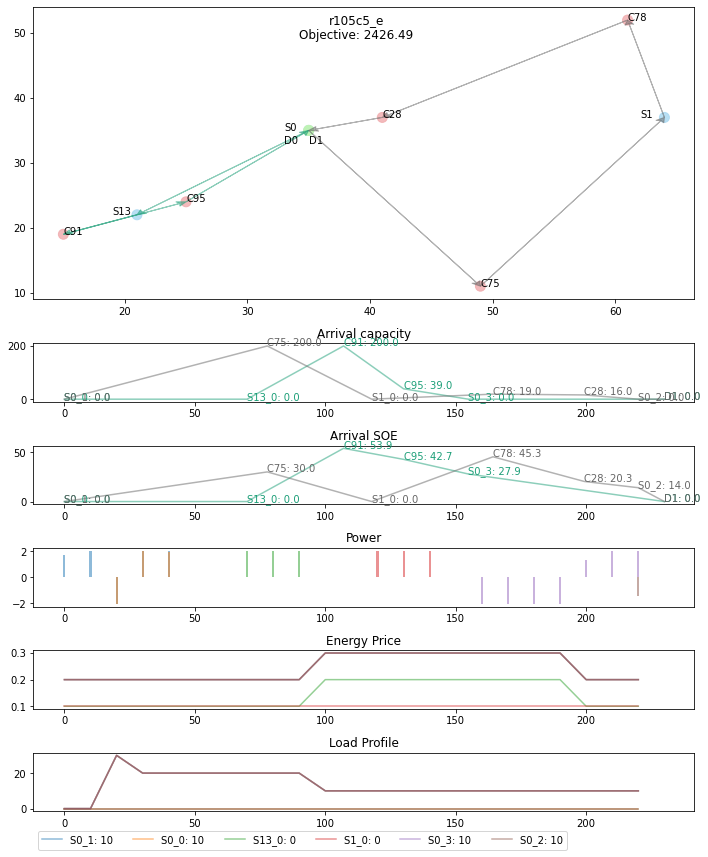

In [1378]:
n_plots = 6
# fig, axs = plt.subplots(n_plots-1, 2, figsize=(10,10), sharex='col', 
#                         gridspec_kw={'width_ratios': [2, 1], 'height_ratios': [1, 1, 1, 1]})

fig = plt.figure(figsize=(10,12))

gs = GridSpec(n_plots, 1, width_ratios=[1], height_ratios=[n_plots-1, 1, 1, 1, 1, 1])
axs0 = fig.add_subplot(gs[0, 0])
axs1 = fig.add_subplot(gs[1, 0])
axs2 = fig.add_subplot(gs[2, 0], sharex=axs1)
axs3 = fig.add_subplot(gs[3, 0], sharex=axs1)
axs4 = fig.add_subplot(gs[4, 0], sharex=axs1)
axs5 = fig.add_subplot(gs[5, 0], sharex=axs1)

title = ''
title += '{}\n'.format(m.instance_name)
title += 'Objective: {}'.format(round(m.instance.obj.expr(), 2))
fig.suptitle(title)

a = 0.5

for i, n in enumerate('SDM'):
    # Plot the nodes
    axs0.scatter(m.data[n]['d_x'], m.data[n]['d_y'], c=[node_colors_rgba_tuple[n]]*len(m.data[n]), s=100)

    # Annotate the nodes
    for j, txt in enumerate(m.data[n].index):
        scale = 2
        if n == 'D':
            offset = [-scale, -scale]
        elif n == 'S':
            offset = [-scale, 0]
        else:
            offset = [0, 0]
        if txt == 'D1':
            offset = [0, -scale]
            
        axs0.annotate(txt, (m.data[n]['d_x'][j]+offset[0], m.data[n]['d_y'][j]+offset[1]))
        
# Get colors for each vehicle
c = plt.get_cmap('Dark2')
colors = [c(tc) for tc in np.linspace(0, 1, len(traces))]
    
# Plot the vehicle routes        
for ti, t in enumerate(traces):
    for ki, k in enumerate(t[:-1]):
        arrow_x = m.data['V_'].loc[t[ki], 'd_x']
        arrow_y = m.data['V_'].loc[t[ki], 'd_y']
        arrow_dx = m.data['V_'].loc[t[ki+1], 'd_x'] - arrow_x
        arrow_dy = m.data['V_'].loc[t[ki+1], 'd_y'] - arrow_y
        
        axs0.arrow(arrow_x, arrow_y, arrow_dx, arrow_dy, alpha=a,
                     length_includes_head=True, head_width=.75, head_length=.75, overhang=.25, color=colors[ti])
        
    # Plot the vehicle states
    r = routes.loc[list(zip(t[:-1], t[1:]))]
    
    # Plot arrival capacity
    axs1.plot(r['xw'], r['xq'], color=colors[ti], alpha=a)
    axs1.title.set_text('Arrival capacity')    
    for row in r.iterrows():
        axs1.annotate('{}: {:.1f}'.format(row[0][1], row[1]['xq']), xy=(row[1]['xw'], row[1]['xq']), color=colors[ti])
    
    # Plot arrival SOE
    axs2.plot(r['xw'], r['xa'], color=colors[ti], alpha=a)
    axs2.title.set_text('Arrival SOE')
    for row in r.iterrows():
        axs2.annotate('{}: {:.1f}'.format(row[0][1], row[1]['xa']), xy=(row[1]['xw'], row[1]['xa']), color=colors[ti])
    
    
# Plot power
stations = xp['node'].unique()
for s in stations:
    axs3.bar(xp[xp['node']==s]['t'], xp[xp['node']==s]['xp'], label=s, alpha=a)
axs3.title.set_text('Power')
# axs[3].set_xlim(0, m.data['Parameters'].loc['t_T'].value)

# Plot energy price
for s in stations:
    axs4.plot(m.data['ce'][m.s_2s[s]], label=s, alpha=a)
axs4.title.set_text('Energy Price')    

# Plot load profiles
for s in stations:
    axs5.plot(m.data['G'][m.s_2s[s]], label='{}: {}'.format(s, m.data['S'].loc[m.s_2s[s], 'cg']), alpha=a)
axs5.title.set_text('Load Profile')  

axs5.legend(loc="upper left", ncol=len(stations), bbox_to_anchor=(0, -.25))

fig.tight_layout()

In [1379]:
m.instance.xd.get_values()

{'S0': 25.918367345999997, 'S1': 2.040816327, 'S13': 2.040816327}

In [1380]:
m.data['G'].max()

S0     30
S1      0
S13     0
dtype: int64

In [1381]:
xp.loc[xp['node']=='S0_1'].head(50)

,node,t,state,xp
23,S0_1,0,1.0,1.698522
24,S0_1,10,1.0,2.040816
25,S0_1,20,1.0,-2.040816
26,S0_1,30,1.0,2.040816
27,S0_1,40,1.0,2.040816


In [1382]:
xp.groupby('node').sum()

,t,state,xp
node,,,
S0_0,90,3.0,1.910497
S0_1,100,5.0,5.780155
S0_2,220,1.0,-1.400839
S0_3,1330,7.0,-2.787539
S13_0,240,3.0,6.063000
S1_0,390,3.0,6.063000


In [1383]:
m.instance.obj.expr()

2426.4937076977776

In [1384]:
sum(sum(sum(m.instance.ce.extract_values()[(s,t)] * m.instance.xp.extract_values()[(i,t)] * m.instance.xkappa.extract_values()[(i,t)] for t in m.instance.T.data()) for i in m.instance.Smap.extract_values()[s]) for s in m.instance.S.data())

1.096728461629606

In [1385]:
xp.groupby('node').describe()

t                                                      state       \
      count   mean        std    min    25%    50%    75%    max count mean   
node                                                                          
S0_0    3.0   30.0  10.000000   20.0   25.0   30.0   35.0   40.0   3.0  1.0   
S0_1    5.0   20.0  15.811388    0.0   10.0   20.0   30.0   40.0   5.0  1.0   
S0_2    1.0  220.0        NaN  220.0  220.0  220.0  220.0  220.0   1.0  1.0   
S0_3    7.0  190.0  21.602469  160.0  175.0  190.0  205.0  220.0   7.0  1.0   
S13_0   3.0   80.0  10.000000   70.0   75.0   80.0   85.0   90.0   3.0  1.0   
S1_0    3.0  130.0  10.000000  120.0  125.0  130.0  135.0  140.0   3.0  1.0   

       ...              xp                                                    \
       ...  75%  max count      mean       std       min       25%       50%   
node   ...                                                                     
S0_0   ...  1.0  1.0   3.0  0.636832  2.319827 -2.040816 -0.065160  1.910497   
S0_1   ...  1.0  1.0   5.0  1.156031  1.793228 -2.040816  1.698522  2.040816   
S0_2   ...  1.0  1.0   1.0 -1.400839       NaN -1.400839 -1.400839 -1.400839   
S0_3   ...  1.0  1.0   7.0 -0.398220  2.063743 -2.040816 -2.040816 -2.040816   
S13_0  ...  1.0  1.0   3.0  2.021000  0.034323  1.981367  2.011092  2.040816   
S1_0   ...  1.0  1.0   3.0  2.021000  0.017161  2.011092  2.011092  2.011092   

                           
            75%       max  
node                       
S0_0   1.975657  2.040816  
S0_1   2.040816  2.040816  
S0_2  -1.400839 -1.400839  
S0_3   1.667455  2.040816  
S13_0  2.040816  2.040816  
S1_0   2.025954  2.040816  

[6 rows x 24 columns]

In [776]:
test = [xp.set_index('node').loc[n,'state'] * v for n, v in routes.reset_index('to')['state'].iteritems() if n in xp['node'].unique()]

In [777]:
test[2]

node
S0_0    1.0
S0_0    1.0
S0_0    1.0
S0_0    1.0
S0_0    1.0
S0_0    1.0
S0_0    1.0
S0_0    1.0
S0_0    1.0
S0_0    1.0
S0_0    1.0
S0_0    1.0
S0_0    1.0
S0_0    1.0
S0_0    1.0
S0_0    1.0
S0_0    1.0
S0_0    1.0
S0_0    1.0
S0_0    1.0
S0_0    1.0
S0_0    1.0
S0_0    1.0
S0_0    1.0
S0_0    1.0
S0_0    1.0
S0_0    1.0
S0_0    1.0
S0_0    1.0
S0_0    1.0
S0_0    1.0
Name: state, dtype: float64

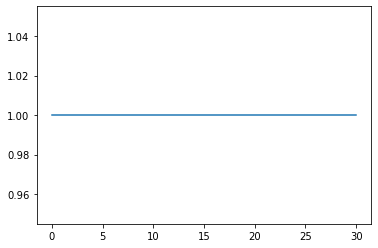

In [778]:
plt.plot(test[2].values)

In [779]:
m.instance.constraint_energy_ev_power_lb.display()

constraint_energy_ev_power_lb : Size=1150
    Key            : Lower : Body                : Upper
       ('S0_0', 0) :  None :                 0.0 :   0.0
       ('S0_0', 1) :  None :                 0.0 :   0.0
       ('S0_0', 2) :  None :        -4.081632654 :   0.0
       ('S0_0', 3) :  None :        -6.122448981 :   0.0
       ('S0_0', 4) :  None :        -8.163265308 :   0.0
       ('S0_0', 5) :  None :       -10.204081635 :   0.0
       ('S0_0', 6) :  None :       -12.244897962 :   0.0
       ('S0_0', 7) :  None :       -14.285714289 :   0.0
       ('S0_0', 8) :  None :       -16.326530616 :   0.0
       ('S0_0', 9) :  None :       -18.367346943 :   0.0
      ('S0_0', 10) :  None :        -20.40816327 :   0.0
      ('S0_0', 11) :  None : -22.448979596999997 :   0.0
      ('S0_0', 12) :  None :       -24.489795924 :   0.0
      ('S0_0', 13) :  None :       -26.530612251 :   0.0
      ('S0_0', 14) :  None :       -28.571428578 :   0.0
      ('S0_0', 15) :  None : -30.6122449049999

In [780]:
routes

state     xw     xq         xa  from_d_x  from_d_y  to_d_x  to_d_y
from to                                                                      
D0   S0_0    1.0    0.0    0.0   0.000000        35        35      35      35
     S0_1    1.0    0.0    0.0   0.000000        35        35      35      35
     S0_2    1.0    0.0    0.0   0.000000        35        35      35      35
S0_2 C75     1.0   79.0  200.0  27.784888        35        35      49      11
S0_1 C91     1.0  107.0  200.0  26.046409        35        35      15      19
C91  C95     1.0  160.0   39.0  14.866069        15        19      25      24
S0_0 C78     1.0  178.0   19.0  31.324555        35        35      61      52
C78  C28     1.0  213.0   16.0   6.324555        61        52      41      37
C28  D1      1.0  230.0    0.0   0.000000        41        37      35      35
C75  D1      1.0  230.0    0.0   0.000000        49        11      35      35
C95  D1      1.0  230.0    0.0   0.000000        25        24      35      35